In [14]:
# Load libraries 
import torch 
import torchvision 
import torchvision.transforms as transforms 
import torch.optim as optim 
import torch.nn as nn 
import torch.nn.functional as F 
import random 
import numpy as np 

In [15]:
# Load and normalise data 
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

train_batch_size, test_batch_size = 128, 1024
trainset = torchvision.datasets.CIFAR100(root = './data', train = True, download = True, transform = transformation)
testset = torchvision.datasets.CIFAR100(root = './data', train = False, download = True, transform = transformation)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = train_batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = test_batch_size, shuffle = False)

num_classes = 100

Files already downloaded and verified
Files already downloaded and verified


In [17]:
# Load generalist model (resnet-20)
generalist_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained = False)
generalist_state_dict = torch.load("teacher_model_cifar100.pth", map_location = torch.device('cpu'))
generalist_model.load_state_dict(generalist_state_dict)
if torch.cuda.is_available(): 
    generalist_model = generalist_model.cuda() 

Using cache found in C:\Users\yeewenli/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [18]:
import torch.nn.functional as F
def get_output(model, dataloader):  
    outputs_array = torch.zeros(10000, 100)
    i = 0 
    with torch.no_grad(): 
        for data in dataloader: 
            images, labels = data 
            if torch.cuda.is_available(): 
                images, labels = images.cuda(), labels.cuda() 
                
            outputs = model(images)
            num_examples_per_batch = labels.shape[0]
            for index in range(num_examples_per_batch): 
                #dist = F.softmax(outputs[index])
                outputs_array[i] = outputs[index].detach().cpu()
                i += 1
    return outputs_array

In [19]:
outputs = get_output(generalist_model, testloader)
outputs_t = outputs.T
covariance_matrix = torch.cov(outputs_t)

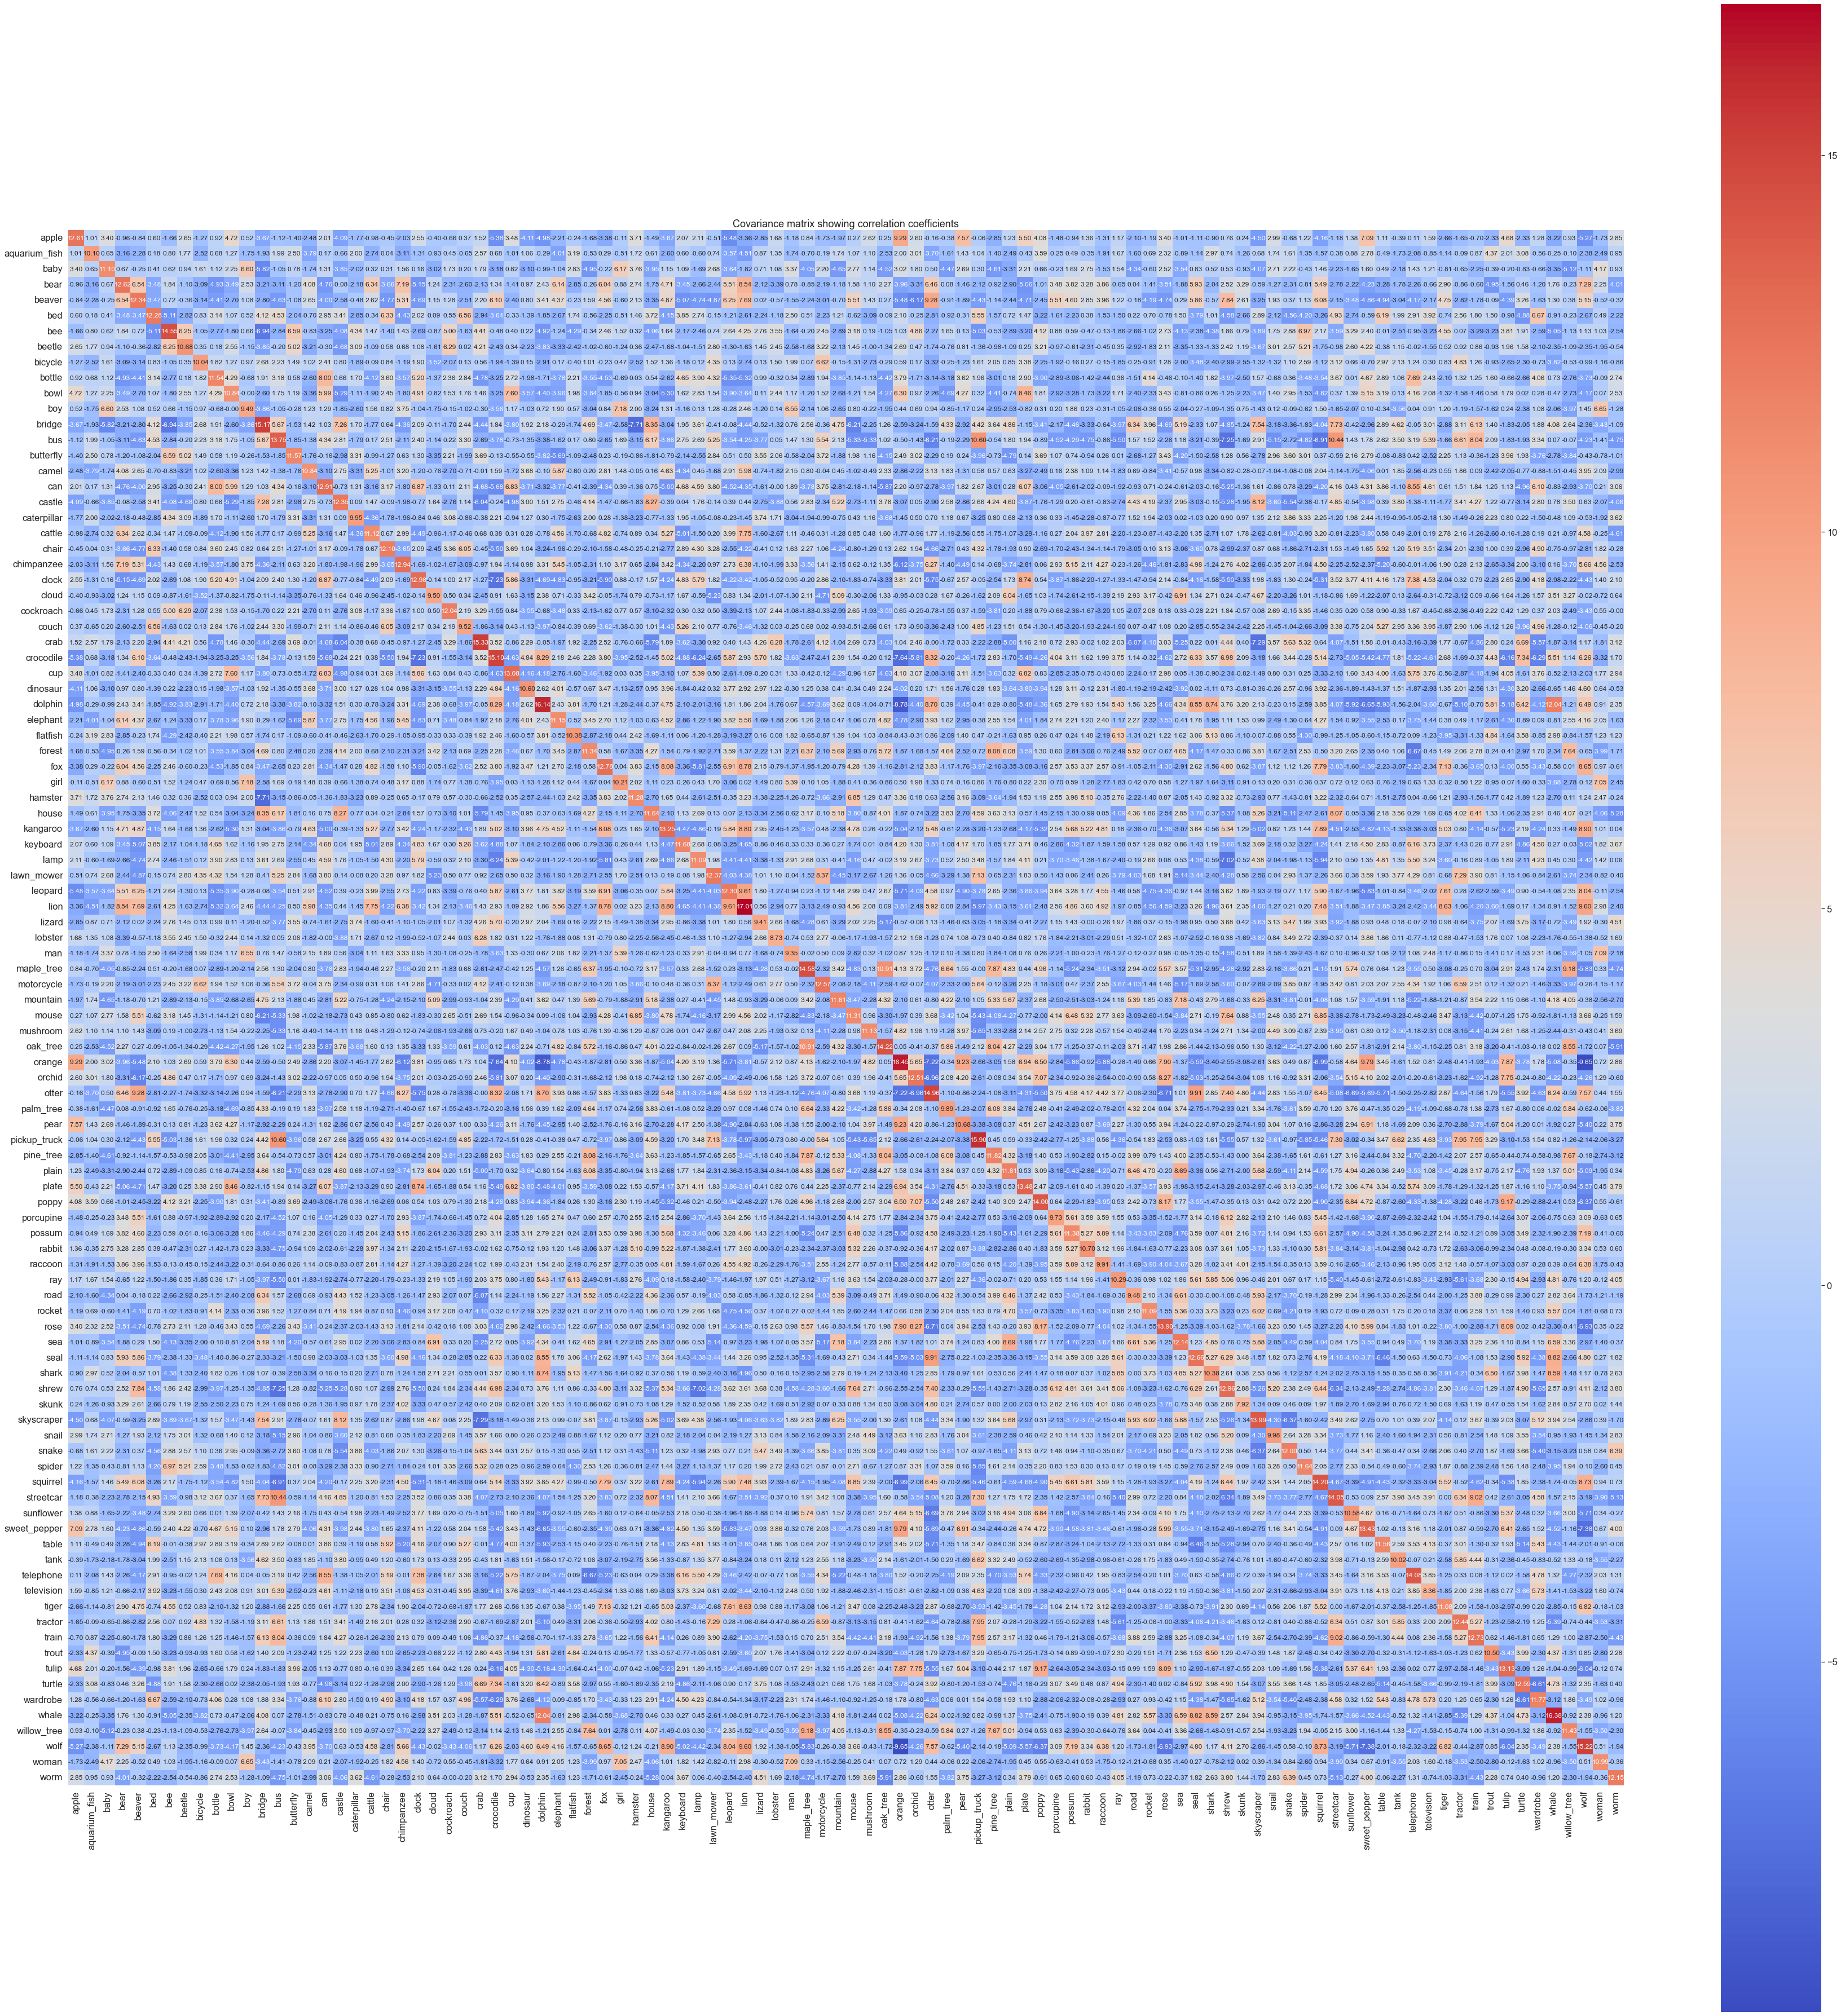

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (50, 50))
sns.set(font_scale=1.5)
hm = sns.heatmap(covariance_matrix, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws = {'size': 12}, cmap = 'coolwarm', yticklabels = testset.classes, xticklabels = testset.classes)
plt.title('Covariance matrix showing correlation coefficients', size = 18)
plt.tight_layout()
plt.show() 

In [8]:
# K-means clustering 
!pip install kmeans-pytorch
from kmeans_pytorch import kmeans, kmeans_predict
# set device
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [13]:
num_clusters = 4
cluster_ids_x, cluster_centers = kmeans(X = covariance_matrix, num_clusters = num_clusters, distance = 'euclidean', device = device)

running k-means on cpu..


[running kmeans]: 9it [00:00, 288.90it/s, center_shift=0.000000, iteration=9, tol=0.000100]  


In [14]:
print(cluster_ids_x)

tensor([2, 0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 0, 3, 3, 0, 1, 2, 3, 0, 1, 2, 1, 2, 3,
        0, 2, 0, 1, 2, 1, 1, 1, 0, 3, 1, 0, 0, 3, 1, 2, 2, 2, 1, 1, 0, 0, 2, 3,
        2, 3, 1, 0, 3, 2, 2, 1, 3, 2, 3, 3, 3, 2, 2, 1, 1, 1, 1, 0, 3, 3, 2, 3,
        1, 0, 1, 1, 3, 0, 0, 0, 1, 3, 2, 2, 2, 3, 2, 2, 1, 3, 3, 0, 2, 0, 2, 1,
        3, 1, 0, 0])


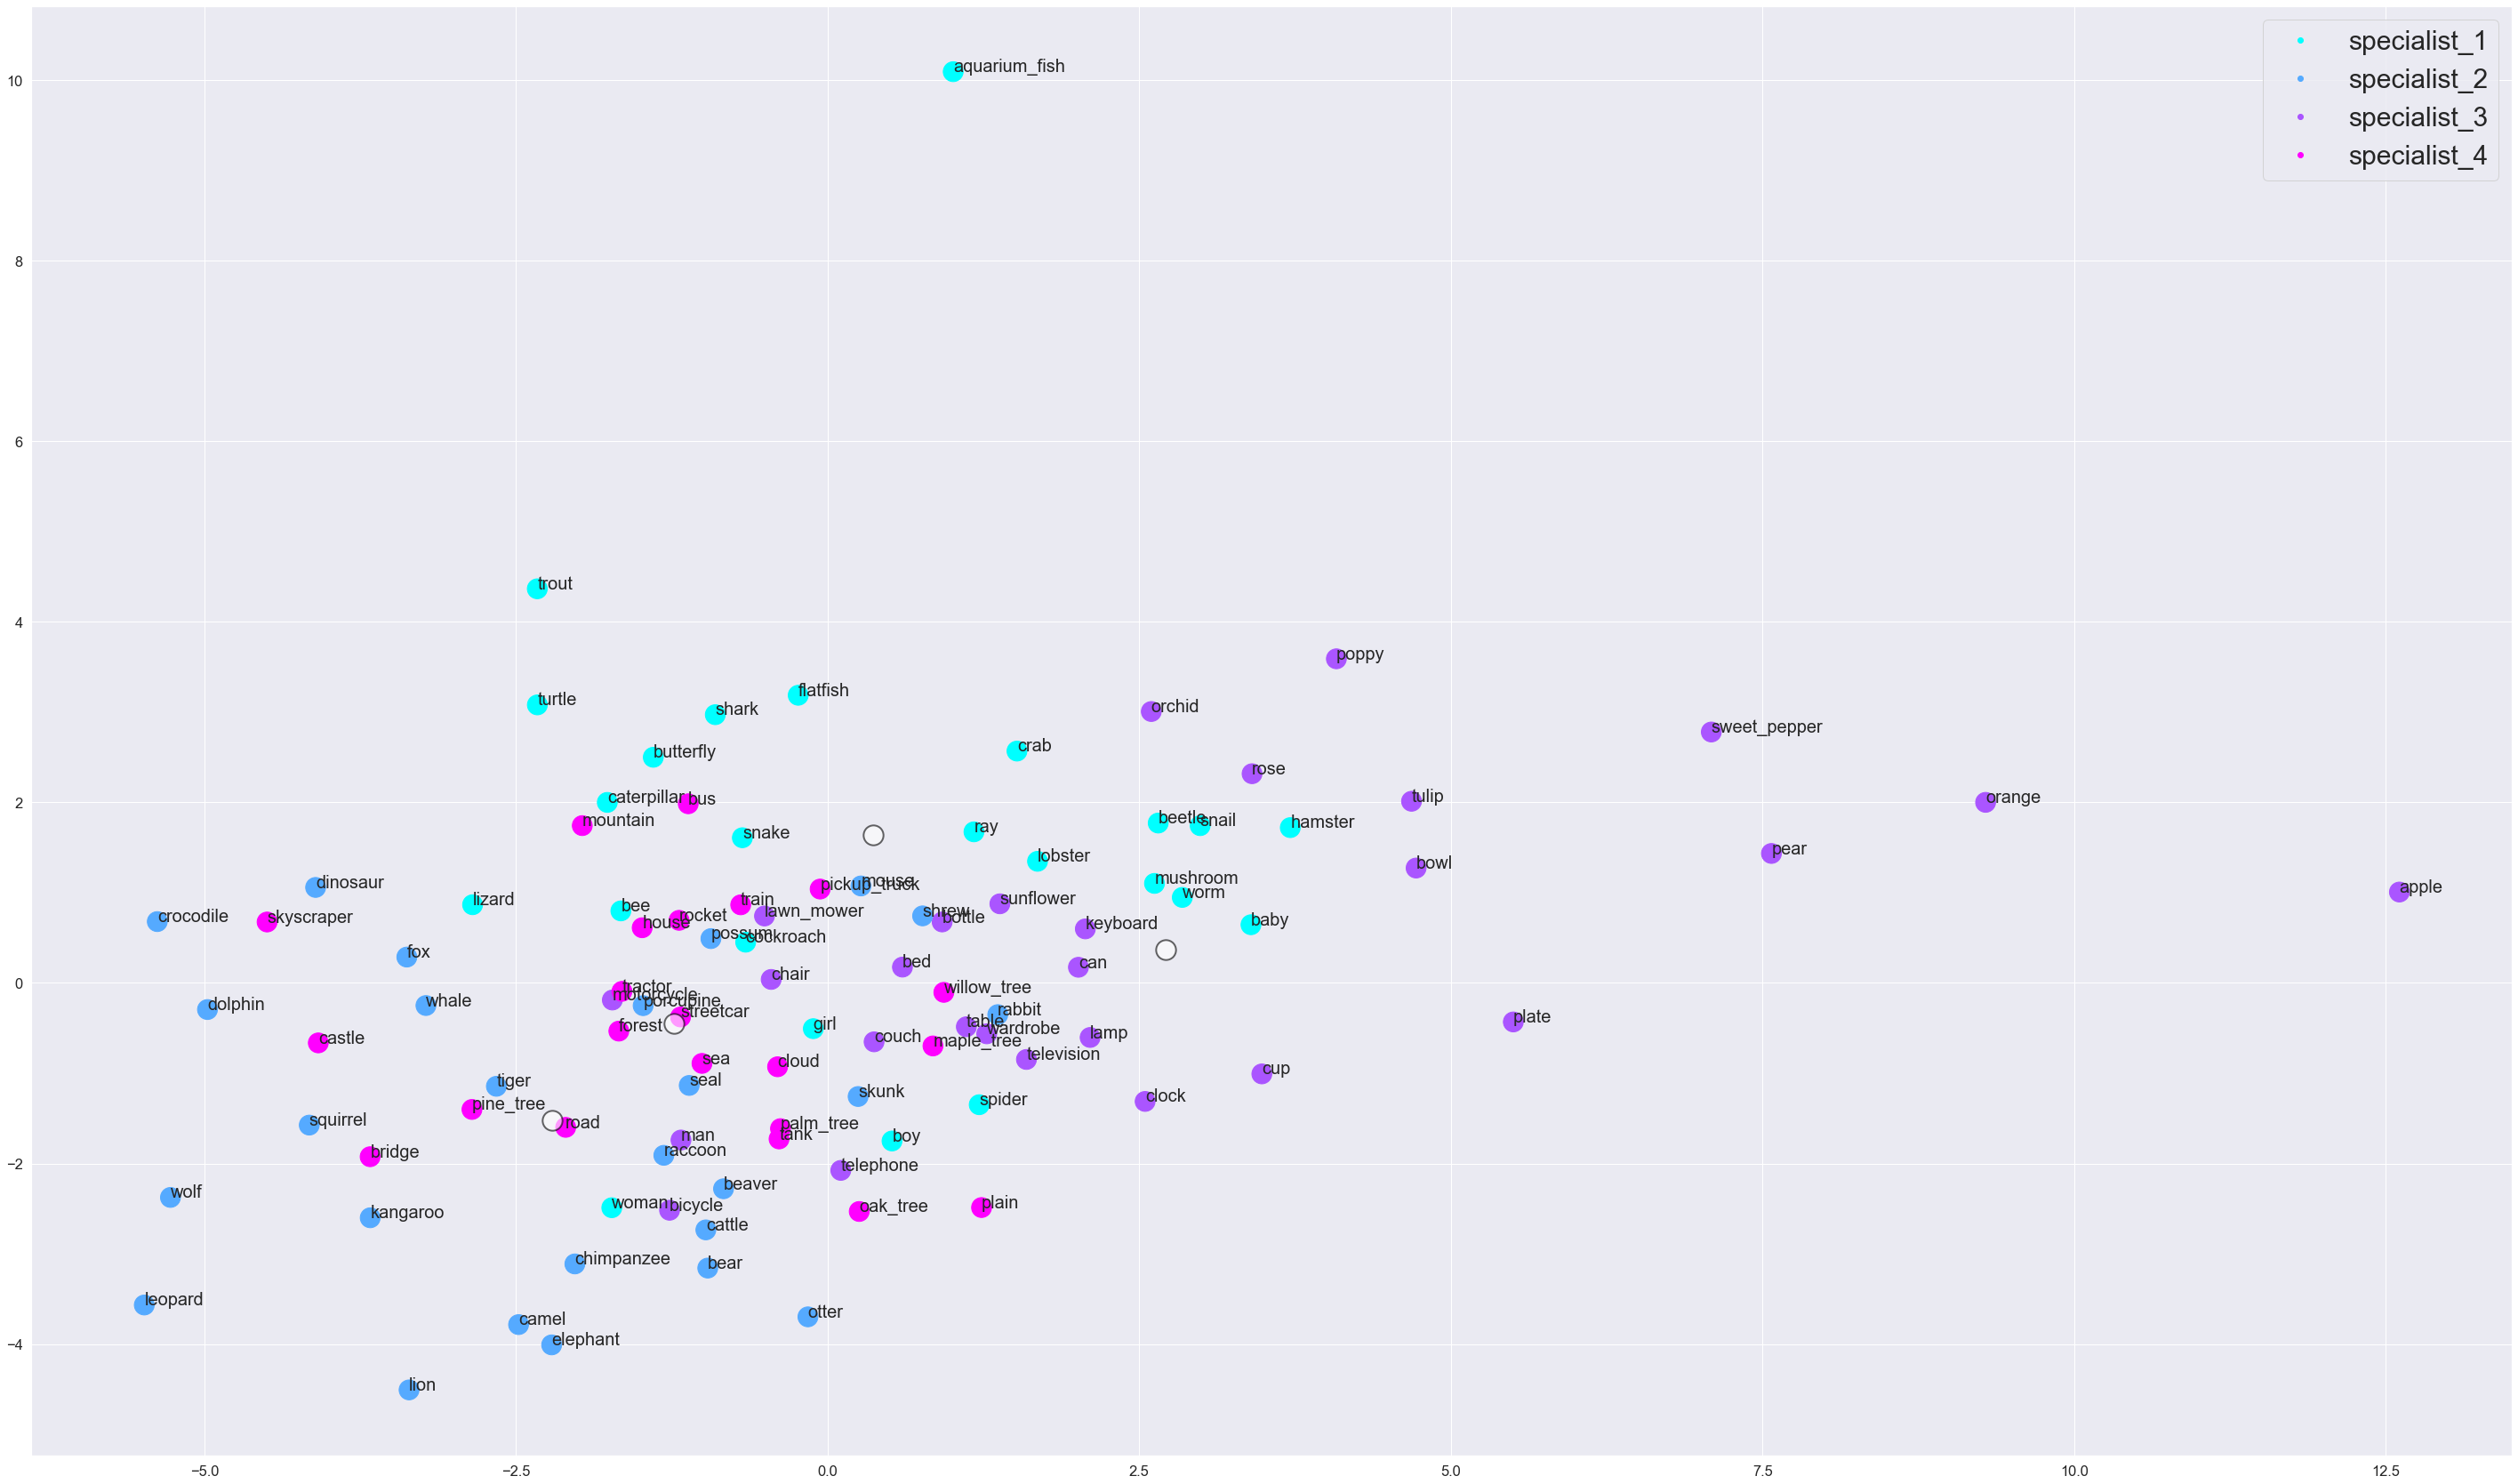

In [15]:
plt.figure(figsize = (50, 30))
scatter = plt.scatter(covariance_matrix[:, 0], covariance_matrix[:, 1], s= 500, c=cluster_ids_x, cmap='cool')
plt.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1], s= 500,
    c='white',
    alpha=0.6,
    edgecolors='black',
    linewidths=2
)
for i in range(100): 
    plt.annotate(testset.classes[i], (covariance_matrix[i, 0], covariance_matrix[i, 1]), fontsize = 20)
#plt.tight_layout()
legend_names = []
for i in range(num_clusters): 
    legend_names.append('specialist_' + str(i+1))
plt.legend(handles =scatter.legend_elements()[0], labels = legend_names, fontsize = 30 )
plt.show()

In [16]:
for i in range(num_clusters): 
    sub_classes = [] 
    for j in range(len(cluster_ids_x)): 
        if cluster_ids_x[j] == i: 
            sub_classes.append(testset.classes[j])
    
    print(f'sub-classes for specialist{i+1}: {sub_classes}')

sub-classes for specialist1: ['aquarium_fish', 'baby', 'bee', 'beetle', 'boy', 'butterfly', 'caterpillar', 'cockroach', 'crab', 'flatfish', 'girl', 'hamster', 'lizard', 'lobster', 'mushroom', 'ray', 'shark', 'snail', 'snake', 'spider', 'trout', 'turtle', 'woman', 'worm']
sub-classes for specialist2: ['bear', 'beaver', 'camel', 'cattle', 'chimpanzee', 'crocodile', 'dinosaur', 'dolphin', 'elephant', 'fox', 'kangaroo', 'leopard', 'lion', 'mouse', 'otter', 'porcupine', 'possum', 'rabbit', 'raccoon', 'seal', 'shrew', 'skunk', 'squirrel', 'tiger', 'whale', 'wolf']
sub-classes for specialist3: ['apple', 'bed', 'bicycle', 'bottle', 'bowl', 'can', 'chair', 'clock', 'couch', 'cup', 'keyboard', 'lamp', 'lawn_mower', 'man', 'motorcycle', 'orange', 'orchid', 'pear', 'plate', 'poppy', 'rose', 'sunflower', 'sweet_pepper', 'table', 'telephone', 'television', 'tulip', 'wardrobe']
sub-classes for specialist4: ['bridge', 'bus', 'castle', 'cloud', 'forest', 'house', 'maple_tree', 'mountain', 'oak_tree', '